In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/Dropbox/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText



/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
data_dir = '/Users/gbromley/Dropbox/CRUTS4.01/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'cru_ts4.01.1901.2016.tmp.dat.nc'
vap_file = 'cru_ts4.01.1901.2016.vap.dat.nc'
#vap_file = 'vap/cru_ts3.24.1901.2015.vap.dat.nc'
#nc_vap = xr.open_dataset(data_dir+vap_file)
nc_temp = xr.open_dataset(data_dir+temp_file)
nc_vap = xr.open_dataset(data_dir+vap_file)

In [ ]:
nc_temp

In [3]:
t2m = nc_temp['tmp']
vap = nc_vap['vap']



In [4]:
ngp_mask = xr.open_dataset('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/ngp_mask.nc')
ngp_mask = ngp_mask.rename({'__xarray_dataarray_variable__':'ngp'})
mask = ngp_mask['ngp']


In [5]:
sat_vap = sat_vap_pres(t2m)
t2m = sat_vap - vap

In [6]:
#t_season='AMJ'
#t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2016-01-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38
t2m = t2m.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
mask = mask.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
#ggw_lat,ggw_lon = 48.18, -106.635

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


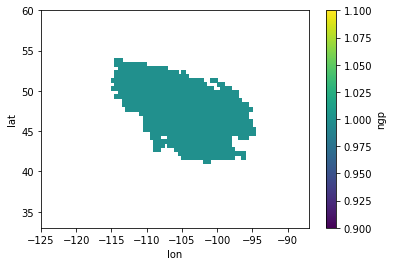

In [8]:
mask.plot()


In [9]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))


#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))

#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_30.groupby('time.month').mean(dim='time')

In [10]:
t2m_new = t2m_slice.groupby('time.month').apply(lambda x: x.groupby('time.year').mean(dim='time'))

In [11]:
anom = t2m_new - t2m_clim_months_avg

In [12]:
#create 2d structure to hold slope
month = ['January','February','March','April','May','June','July','August','September','October','November','December']
lat = t2m.lat
lon=t2m.lon
vals = np.empty(shape=(12,54,76))
vals[:,:,:] = np.nan
spatial_trend = xr.DataArray(vals,coords=[month,lat,lon],dims=['month','lat','lon'])
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'

#spatial_trend = xr.DataArray(np.random.rand(4,54,76),coords=[season,lat,lon],dims=['season','lat','lon'])


slope_scipy = t2m.isel(time=1).copy(deep=True)
#create 2d structure to hold pvalues
lat = t2m.lat
lon=t2m.lon
pvalues = xr.DataArray(np.random.rand(12,54,76),coords=[month,lat,lon],dims=['month','lat','lon'])
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [13]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(anom.year))
corr_vals = sm.add_constant(corr_vals)
for k in np.arange(0,12):
    for i in np.arange(0,len(anom['lat'])):
        for j in np.arange(0,len(anom['lon'])):
            series = anom[k,i,j,:]
            model = sm.OLS(series.values,corr_vals)
            ac_coe = sm.tsa.stattools.acf(series.values)
            #model = sm.OLS(series.values,corr_vals)
            #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
            results = model.fit()
            slope = results.params[1]
            adjusted_error = results.bse[1] * (np.sqrt((1-ac_coe[1])/(1+ac_coe[1])))
            t_value = ((slope)/adjusted_error)
            #tw0-sided
            p_value = 2*(1-stats.t.cdf(abs(t_value), results.df_resid))
            #t_value = ((slope - 0.02)/results.bse[1])
            #p_value = stats.t.cdf(t_value, results.df_resid)
            #p_value = stats.t.sf(results.tvalues[0], results.df_resid)
            spatial_trend[k,i,j]=slope*10
            #slope_scipy[i,j] = slope_2*10
            pvalues[k,i,j]= p_value

In [14]:

ngp = spatial_trend.where(mask==1)
test = ngp.stack(z=('lat','lon'))

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [15]:
season_values = test.groupby('month').apply(lambda x: x.dropna(dim='z'))

In [21]:
season_values

<xarray.DataArray (month: 12, z: 636)>
array([[-0.000735, -0.019632,  0.010282, ..., -0.083743, -0.024066, -0.034755],
       [-0.163216, -0.162675, -0.198028, ..., -0.099796, -0.069746, -0.06331 ],
       [ 0.168739,  0.142816,  0.109608, ..., -0.033355, -0.028525, -0.029159],
       ...,
       [-0.122963, -0.136387, -0.133026, ..., -0.066566, -0.093774, -0.091221],
       [ 0.096185,  0.079978,  0.052993, ..., -0.032088, -0.03498 , -0.034657],
       [-0.190847, -0.174296, -0.188322, ..., -0.080834, -0.031283, -0.029116]])
Coordinates:
  * z        (z) MultiIndex
  - lat      (z) float64 41.25 41.25 41.75 41.75 41.75 41.75 41.75 41.75 ...
  - lon      (z) float64 -101.8 -101.2 -104.8 -104.2 -103.8 -103.2 -102.8 ...
  * month    (month) <U9 'January' 'February' 'March' 'April' 'May' 'June' ...
Attributes:
    units:      C per Decade
    long_name:  2 meter temperature trend

Text(0,0.5,'VPD Trend hPa/Decade')

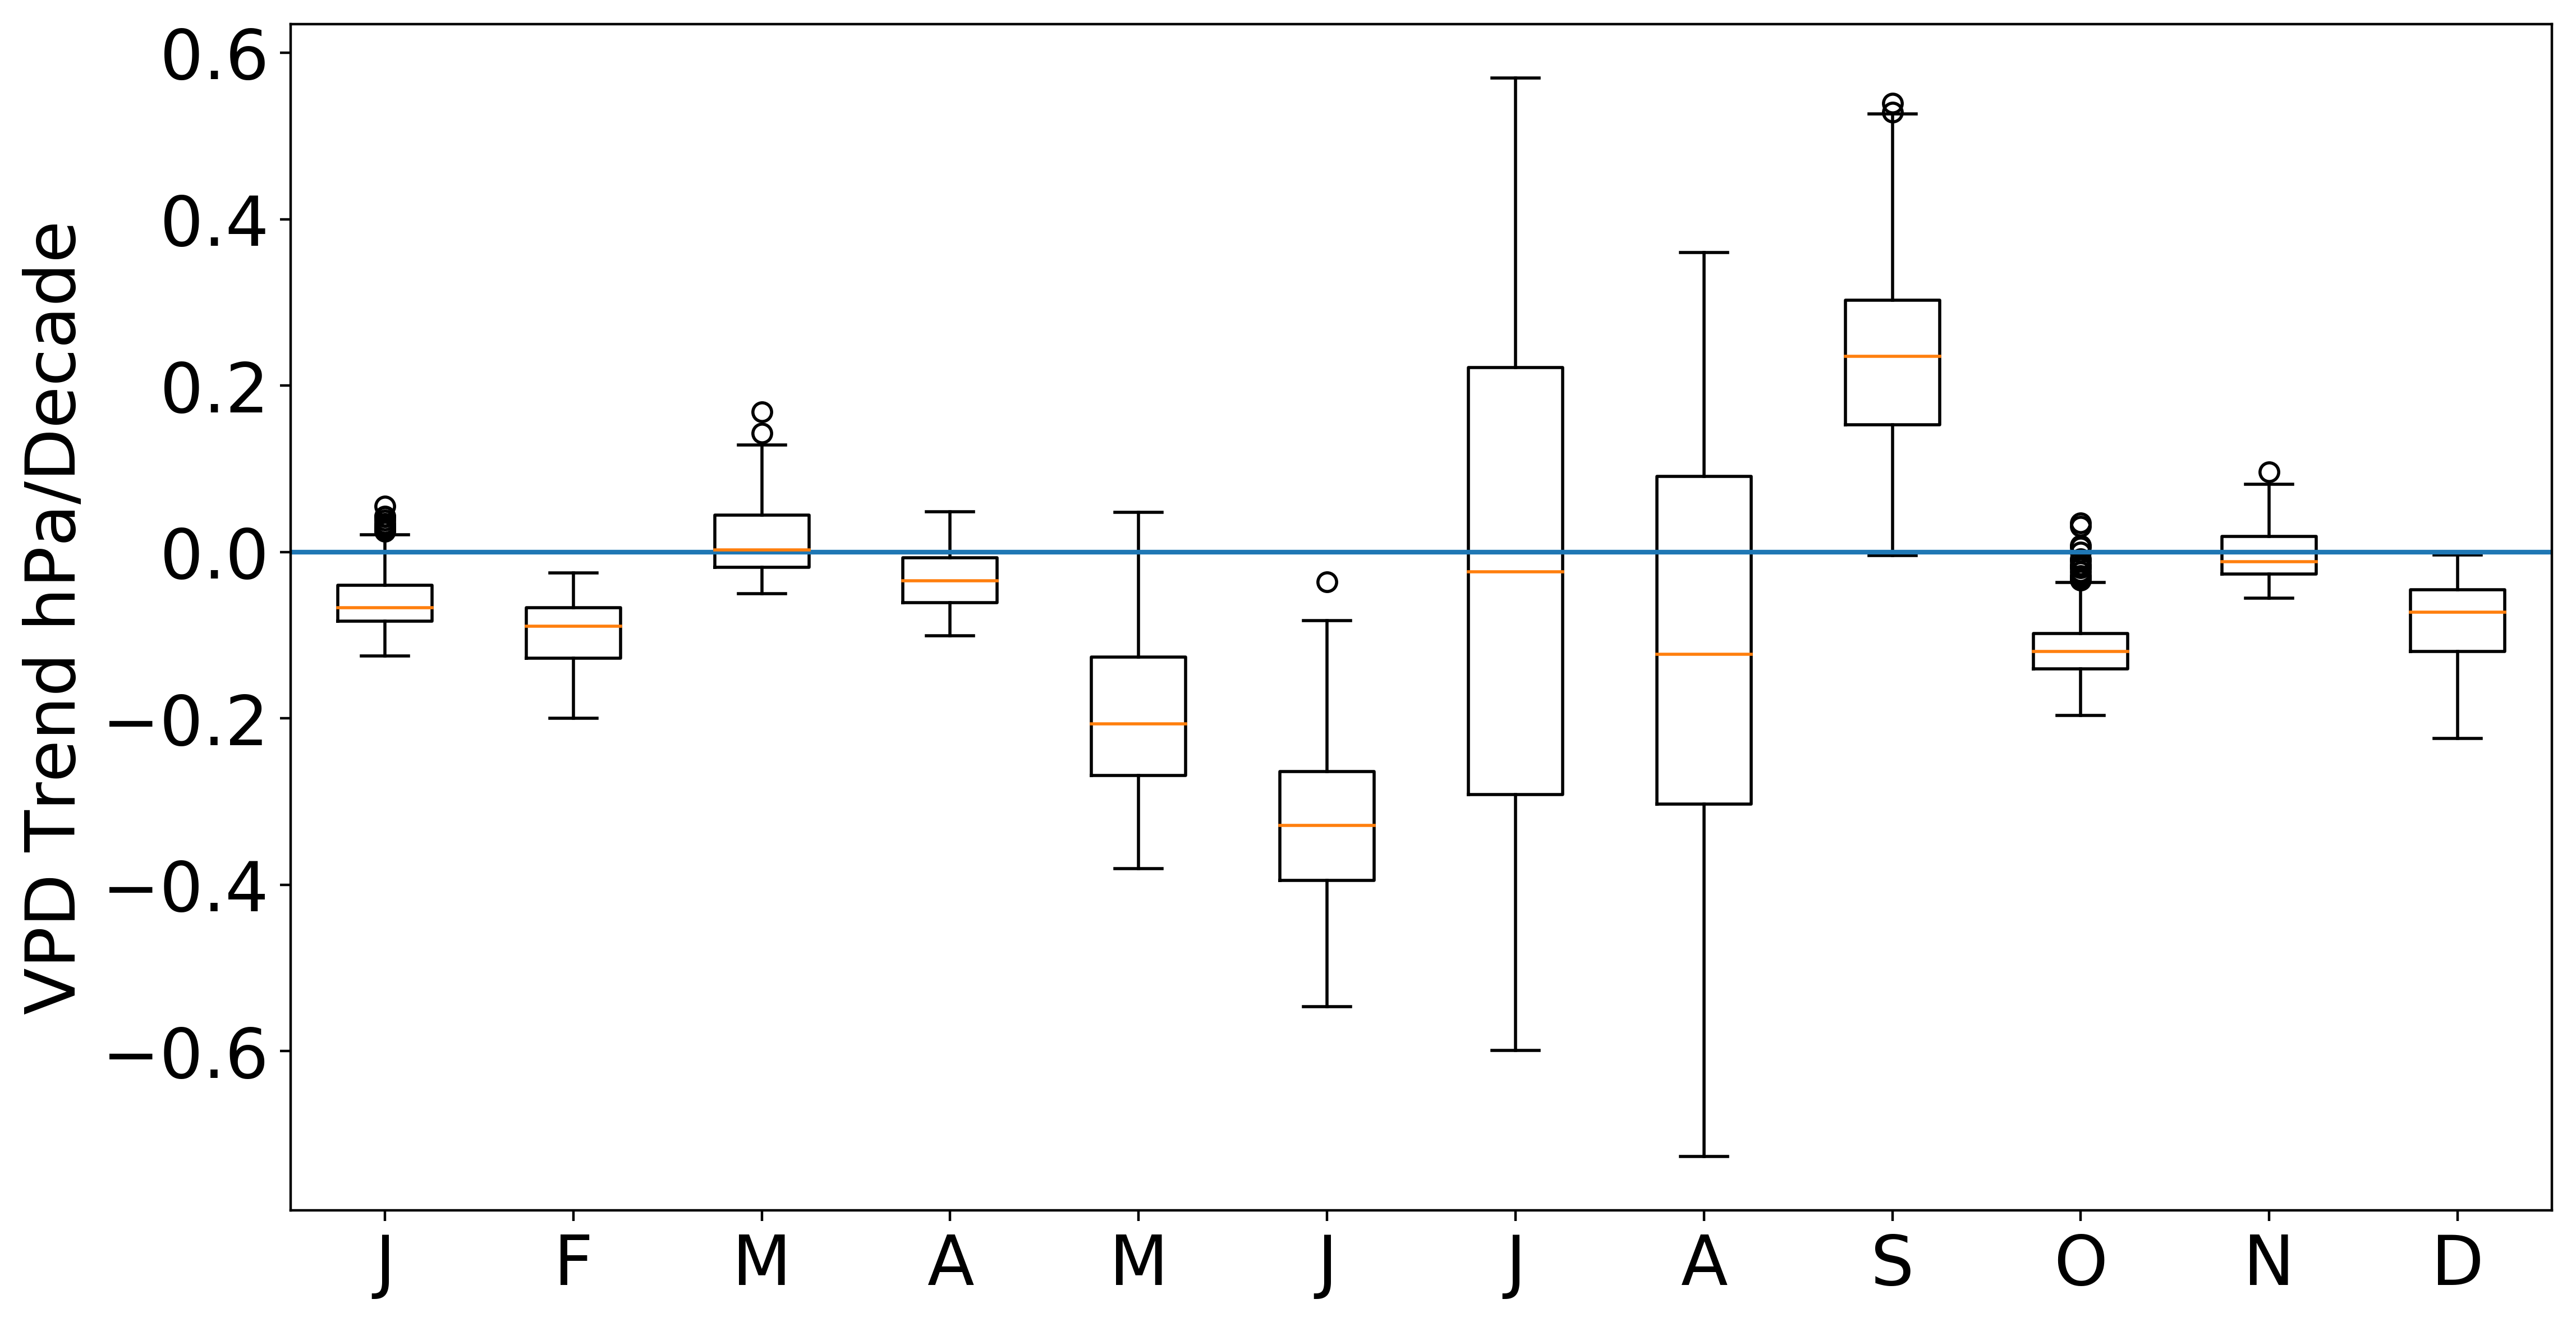

In [16]:
plt.rcParams.update({'font.size': 22})
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
fig, ax = plt.subplots(ncols=1)
fig.set_dpi(400)
fig.set_size_inches((13,7))
pos = np.array(range(len(season_values))) + 1
plt.boxplot(season_values, positions=pos)
plt.xticks([1, 2, 3,4,5,6,7,8,9,10,11,12], month)
ax.axhline(0)
ax.set_ylabel('VPD Trend hPa/Decade')
#plt.savefig('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/vpd_trend_boxplots.png',bbox_inches='tight')


In [ ]:
spatial_trend[8,:,:]